# Try GP model

Started: May 8, 2020.
Updated: July 28, 2020.

- Alternatively we could use a multilayer preceptron with MC-Dropout (following Yarin Gal), but there is some discussion about what this acutally measures (for this reason I now also moved back to GP for some of my projects).

In [26]:
import os 

import pandas as pd 
import numpy as np 
import GPy
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import joblib

import matplotlib.pyplot as plt 
%matplotlib inline 

DATADIR = '../data'
TRAIN_SIZE = 0.10

import sys
sys.path.append('..')
from dispersant_screener.definitions import *

## Load the data

- For the startification we need to look into it.

In [27]:
df_full_factorial = pd.read_csv(os.path.join(DATADIR, 'full_fact.csv'))

In [28]:
NFEAT = len(FEATURES)
NFEAT

19

In [29]:
!ls ../data/b1-b21_random_virial_large.csv

../data/b1-b21_random_virial_large.csv


In [30]:
df_full_factorial = pd.read_csv(os.path.join(DATADIR, 'full_fact.csv'))
new_A2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large.csv'))['A2_normalized']
# new_A2 = pd.read_csv(os.path.join(DATADIR, 'b1-b21_random_virial_large.csv'))['A2_unnormalized']

# replace old A2 values with newly calculated values
df_full_factorial['A2_normalized'] = new_A2
df_full_factorial['1_N'] = df_full_factorial['total_count']

In [102]:
X = df_full_factorial[FEATURES]
y = df_full_factorial[TARGETS]



X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)

# split responses so when scaling so that we can perform inverse transform on each one individually

feat_scaler = StandardScaler()
X = feat_scaler.fit_transform(X_train)
X = feat_scaler.transform(X_test)


label1_scaler = StandardScaler()
y1_train = label1_scaler.fit_transform(np.array(y_train)[:,0].reshape(-1,1))
y1_test = label1_scaler.transform(np.array(y_test)[:,0].reshape(-1,1))

label2_scaler = StandardScaler()
y2_train = label2_scaler.fit_transform(np.array(y_train)[:,1].reshape(-1,1))
y2_test = label2_scaler.transform(np.array(y_test)[:,1].reshape(-1,1))

312


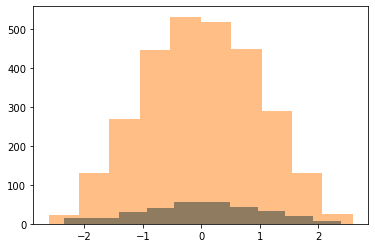

In [103]:
plt.hist(y1_train)
plt.hist(y1_test,alpha=0.5)
print(len(y2_train))

312


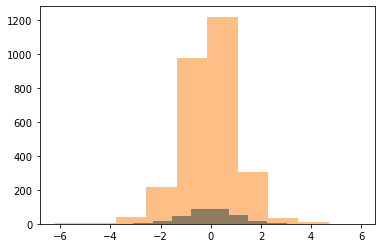

In [104]:
plt.hist(y2_train)
plt.hist(y2_test,alpha=0.5)
print(len(y2_train))

# Scikitlearn GP

In [105]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso

def CV_GP(X, y, tuned_parameters=None, n_splits=5, normalize_y = False, scoring = 'neg_root_mean_squared_error'):
    # define cross-validation + grid-search function
    # since our y is scaled already, we will set normalize y to false
    # note: we scale y since we assume a prior with mean of zero
    # cross_validate by default uses asynchronous parallelization (n_jobs=-1 is all processors available)
    
    # returns basic fit with cross_validation results
    if tuned_parameters is None:
        model = GaussianProcessRegressor(kernel=RBF(), normalize_y=normalize_y, n_restarts_optimizer=30)
        kfold = KFold(n_splits, shuffle=True)
        cv_results = cross_validate(model, X, y, cv=kfold)
        model.fit(X,y)
        return(model, cv_results)
    # perform grid-search
    else:
        model = GaussianProcessRegressor()
        estimatorCV = GridSearchCV(model, 
                                   tuned_parameters, 
                                   cv=KFold(n_splits, shuffle=True), 
                                   n_jobs=-1, 
                                   scoring=scoring,
                                   error_score=0,
                                   return_train_score=True
                                  )
        estimatorCV.fit(X,y)
        best_params = estimatorCV.best_params_
        cv_results = estimatorCV.cv_results_
        best_model = GaussianProcessRegressor().set_params(**best_params)
        best_model = best_model.fit(X,y)
        
        return (best_model, best_params, cv_results)



def build_virial_model():
    virial_model = GaussianProcessRegressor(kernel=RBF(), normalize_y=False, n_restarts_optimizer=30)

    return virial_model


def build_gibbs_model():
    gibbs_model = GaussianProcessRegressor(kernel=RBF(), normalize_y=False, n_restarts_optimizer=30)

    return gibbs_model

In [106]:
# virial_model = build_virial_model()
# virial_model.fit(X_train, y_train[:,1].reshape(-1,1))


# define grid-search parameters
tuned_parameters = [{
    
    'kernel': [
        # radial basis function kernel with varying correlation length_scale
         RBF() + DotProduct()
#                DotProduct(0.1), DotProduct(0.5), 
#                
#                Matern(0.01,length_scale_bounds="fixed", nu=0.5), Matern(0.1,length_scale_bounds="fixed",  nu=0.5),
#                Matern(0.05,nu=1.5), Matern(0.1,nu=1.5),
#                Matern(0.01,nu=2.5), Matern(0.1,nu=2.5),
              ], 
                     # gaussian noise height
#                      'alpha': [0.1],
                     'n_restarts_optimizer': [20],
                    },
                   ]
# set grid-search to false
# tuned_parameters = None

# fit GP model to virial
virial_model, virial_params, virial_cv_results = CV_GP(X_train, 
                   y2_train, tuned_parameters, 5)


In [107]:
virial_params

{'kernel': RBF(length_scale=1) + DotProduct(sigma_0=1),
 'n_restarts_optimizer': 20}

In [108]:
virial_cv_results['mean_train_score']

array([-9.69924158e-11])

In [109]:
virial_cv_results['mean_test_score']

array([-1.02829878])

In [110]:
y2_hat_trn, y2_std_trn = virial_model.predict(X_train[:], return_std=True)
y2_hat_tst, y2_std_tst = virial_model.predict(X_test[:], return_std=True)

 /Users/brianyoo/anaconda3/envs/pal/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.
 /Users/brianyoo/anaconda3/envs/pal/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


Text(0.5, 1.0, 'Virial (test)')

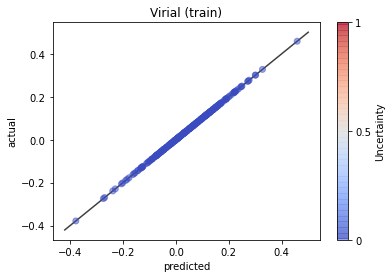

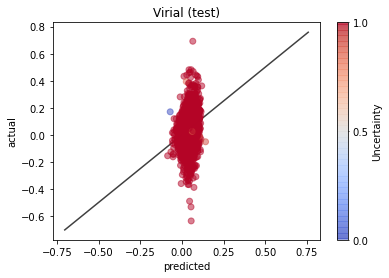

In [111]:
import matplotlib as mpl

plt.close('all')



fig, ax = plt.subplots()
sc = plt.scatter(label2_scaler.inverse_transform(y2_hat_trn), 
                 label2_scaler.inverse_transform(y2_train), 
                 alpha=0.5, c=y2_std_trn, cmap=plt.cm.coolwarm, norm = mpl.colors.Normalize(vmin=0, vmax=1))
cb = plt.colorbar(sc)
cb.set_label('Uncertainty', rotation=90)
# cb.ax.tick_params(size=0)
cb.set_ticks([0,0.5,1])
cb.set_ticklabels([0,0.5,1])
plt.ylabel('actual')
plt.xlabel('predicted')
# plt.legend(['test', 'train',])
plt.title('Virial (train)')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.75,  zorder=0)

fig, ax = plt.subplots()
sc = plt.scatter(label2_scaler.inverse_transform(y2_hat_tst), 
                 label2_scaler.inverse_transform(y2_test), 
                 alpha=0.5, c=y2_std_tst, cmap=plt.cm.coolwarm, norm = mpl.colors.Normalize(vmin=0, vmax=1))
cb = plt.colorbar(sc)
cb.set_label('Uncertainty', rotation=90)
cb.ax.tick_params(size=1)
cb.set_ticks([0,0.5,1])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.ylabel('actual')
plt.xlabel('predicted')
plt.title('Virial (test)')

Try using isomaps to reduce feature dimensions

In [112]:
# X = df_full_factorial[FEATURES]
# y = df_full_factorial[TARGETS]

# import random
# X = df_full_factorial[FEATURES]
# l = np.arange(len(X))
# random.shuffle(l) # we shuffle the list
# ix = l[:300]
# # ix
# X = X.iloc[ix]
# y = y.iloc[ix]

# feat_scaler = StandardScaler()
# X = feat_scaler.fit_transform(X)
# TRAIN_SIZE=0.9
# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE)

# # split responses so when scaling so that we can perform inverse transform on each one individually

# label1_scaler = StandardScaler()
# y1_train = label1_scaler.fit_transform(np.array(y_train)[:,0].reshape(-1,1))
# y1_test = label1_scaler.transform(np.array(y_test)[:,0].reshape(-1,1))

# label2_scaler = StandardScaler()
# y2_train = label2_scaler.fit_transform(np.array(y_train)[:,1].reshape(-1,1))
# y2_test = label2_scaler.transform(np.array(y_test)[:,1].reshape(-1,1))

# from sklearn.manifold import SpectralEmbedding, Isomap
# # embedding = Isomap(n_components=1)
# embedding = SpectralEmbedding(n_components=2)

# X_train_transformed = embedding.fit_transform(X_train)
# X_test_transformed = embedding.fit_transform(X_test)


# virial_model, virial_params, virial_cv_results = CV_GP(X_train_transformed, 
#                    y2_train, tuned_parameters, 5)

# X_test_transformed = embedding.fit_transform(X_test)
# y2_hat_trn, y2_std_trn = virial_model.predict(X_train_transformed, return_std=True)
# y2_hat_tst, y2_std_tst = virial_model.predict(X_test_transformed, return_std=True)


In [113]:
# plt.close('all')

# fig, ax = plt.subplots()
# plt.scatter(label2_scaler.inverse_transform(y2_hat_trn), label2_scaler.inverse_transform(y2_train), alpha=0.5)
# plt.plot( [min(label2_scaler.inverse_transform(y2_hat_trn)),max(label2_scaler.inverse_transform(y2_hat_trn))],
#          [min(label2_scaler.inverse_transform(y2_train)),max(label2_scaler.inverse_transform(y2_train))] , color='k')
# plt.ylabel('actual')
# plt.xlabel('predicted')
# # plt.legend(['test', 'train',])
# plt.title('Virial (train)')
# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# # now plot both limits against eachother
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)



# fig, ax = plt.subplots()
# plt.scatter(label2_scaler.inverse_transform(y2_hat_tst), label2_scaler.inverse_transform(y2_test), alpha=0.5, color='orange')

# lims = [
#     np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
#     np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
# ]
# ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
# plt.ylabel('actual')
# plt.xlabel('predicted')
# plt.title('Virial (test)')


In [114]:
tuned_parameters = [{
    
    'kernel': [
        # radial basis function kernel with varying correlation length_scale
         RBF() + DotProduct()
#                DotProduct(0.1), DotProduct(0.5), 
#                
#                Matern(0.01,length_scale_bounds="fixed", nu=0.5), Matern(0.1,length_scale_bounds="fixed",  nu=0.5),
#                Matern(0.05,nu=1.5), Matern(0.1,nu=1.5),
#                Matern(0.01,nu=2.5), Matern(0.1,nu=2.5),
              ], 
                     # gaussian noise height
#                      'alpha': [0.1],
                     'n_restarts_optimizer': [20],
                    },
                   ]

In [115]:
#fit GP model to adsorption free energies
fe_model, fe_params, fe_cv_results = CV_GP(X_train, 
                   y1_train, tuned_parameters)

In [116]:
fe_cv_results['mean_test_score']

array([-0.25913791])

In [117]:
fe_params

{'kernel': RBF(length_scale=1) + DotProduct(sigma_0=1),
 'n_restarts_optimizer': 20}

In [118]:
y1_hat_trn, y1_std_trn = fe_model.predict(X_train, return_std=True)
y1_hat_tst, y1_std_tst = fe_model.predict(X_test, return_std=True)
# yhat_trn

 /Users/brianyoo/anaconda3/envs/pal/lib/python3.8/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning:Predicted variances smaller than 0. Setting those variances to 0.


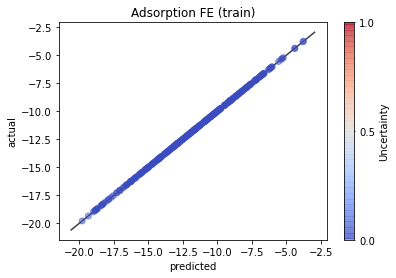

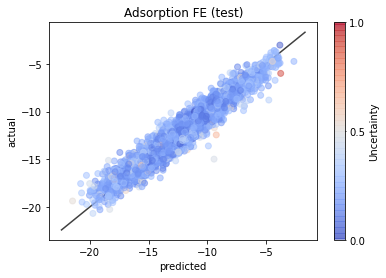

In [119]:
import matplotlib as mpl

plt.close('all')
fig, ax = plt.subplots()
sc = plt.scatter(label1_scaler.inverse_transform(y1_hat_trn), 
                 label1_scaler.inverse_transform(y1_train), 
                 alpha=0.5, c=y1_std_trn, cmap=plt.cm.coolwarm, 
                 norm = mpl.colors.Normalize(vmin=0, vmax=1) )
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
plt.ylabel('actual')
plt.xlabel('predicted')
plt.title('Adsorption FE (train)')

cb = plt.colorbar(sc)
cb.set_label('Uncertainty', rotation=90)
cb.ax.tick_params(size=1)
cb.set_ticks([0,0.5,1])

fig, ax = plt.subplots()
plt.scatter(label1_scaler.inverse_transform(y1_hat_tst), 
            label1_scaler.inverse_transform(y1_test), 
            alpha=0.5, c=y1_std_tst, cmap=plt.cm.coolwarm, 
            norm = mpl.colors.Normalize(vmin=0, vmax=1) )
plt.ylabel('actual')
plt.xlabel('predicted')
plt.title('Adsorption FE (test)')

cb = plt.colorbar(sc)
cb.set_label('Uncertainty', rotation=90)
cb.ax.tick_params(size=1)
cb.set_ticks([0,0.5,1])
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]
ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.show()
# plt.xlim(-0.5,0.5)

## Test a simple sparse GP (GPy) with no interaction between the outputs.

No interaction means we us no coregularization matrix and we can use either sklearn or GPy. 

I will just use RBF for now as I do not know better. Also, I will standardize the labels. 

### Predict Gibbs energy

In [ ]:
K_simple = GPy.kern.Matern32(NFEAT) 
m_gibbs = GPy.models.SparseGPRegression(X_train, y_train[:,0].reshape(-1,1), 
                                                kernel=K_simple, num_inducing=500)

In [ ]:
# m_gibbs.optimize()

In [ ]:
prediction = m_gibbs.predict(X_test)

In [ ]:
plt.scatter(prediction[0].reshape(-1,1), y_test[:,0].reshape(-1,1))
plt.xlabel('normalized Gibbs free energy predicted')
plt.ylabel('normalized Gibbs free energy true')

## Predict the virial

In [ ]:
K_simple = GPy.kern.Matern32(NFEAT) 
m_virial = GPy.models.SparseGPRegression(X_train, y_train[:,1].reshape(-1,1), 
                                                kernel=K_simple, num_inducing=500)

In [ ]:
m_virial.optimize()

In [ ]:
prediction = m_virial.predict(X_test)

In [ ]:
plt.scatter(prediction[0].reshape(-1,1), y_test[:,0].reshape(-1,1))
plt.xlim(-0.5,0.5)

## Test a simple sparse GP with coregionalization

I would expect that coregionalization helps as there is some common physics between the Gibbs energy and the virial ...

In [ ]:
NFEAT = X_train.shape[1]

In [ ]:
K = GPy.kern.Matern32(NFEAT) 
icm = GPy.util.multioutput.ICM(input_dim=NFEAT,num_outputs=2,kernel=K)
m = GPy.models.SparseGPCoregionalizedRegression([X_train, X_train], 
                                                [y_train[:,0].reshape(-1,1), y_train[:,1].reshape(-1,1)], 
                                                kernel=icm, num_inducing=500)

In [ ]:
m

In [ ]:
m.optimize()

In [ ]:
m.plot(visible_dims=[4])

In [ ]:
m

Strange how the inducing points are selected along some feature dimensions ... But nice how it works with little points ;)

### Predicting Gibbs

In [ ]:
newX = np.hstack([X_test,0 * np.ones_like(X_test)])
mu, var =m.predict(newX,Y_metadata={'output_index':0 * np.ones((newX.shape[0],1)).astype(int)})

In [ ]:
plt.scatter(mu1, y_test[:,0])
plt.xlabel('predicted')
plt.ylabel('actual')

The Gibbs energy prediction seems reasonable to me.

### Predicting Virial

In [ ]:
newX = np.hstack([X_test, 1 * np.ones_like(X_test)])
mu, var =m.predict(newX,Y_metadata={'output_index': 1 * np.ones((newX.shape[0],1)).astype(int)})

In [ ]:
plt.scatter(mu, y_test[:,1])
plt.xlabel('predicted')
plt.ylabel('actual')
plt.xlim(-0.5,0.5)

The virial seems really bad to me.

In [ ]:
joblib.dump(m_gibbs, '../models/matern_gibbs.joblib')

In [ ]:
joblib.dump(m_virial, '../models/matern_virial.joblib')

In [ ]:
joblib.dump(m, '../models/coregionalized.joblib')